In [1]:
import os
import pandas as pd
import actr
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

ACT-R connection has been started.


In [2]:
class MiniModel:
    def __init__(self, num_productions=10):
        self.curr_index = 0
        self.curr_onset = 0
        self.curr_offset = 0
        self.curr_production = ""
        self.ordered_productions = ["P"+str(i+1) for i in range(num_productions)]
        self.production_at = np.arange(1, num_productions+1)/100
        self.production_reward = range(num_productions)
        
        self.trial_trace = []
        self.production_trace = []
        self.reward_trace = []
        self.utility_trace = []
    
    def setup_model(self, model="mini-model.lisp", retrieve=True):
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        actr.load_act_r_model(os.path.join(curr_dir, model))
        if retrieve:
            actr.pdisable('skip-retrieval')
        else:
            actr.pdisable('retrieve-rule')
        self.setup_parameters()
    
    def cost_function(self, x, c=1, enable=True):
        return np.round(np.exp(x*c)-1, 4)

    def payoff_function(self, x, c=1, enable=True):
        # sigmoid function
        # use k to adjust the slope
        n = len(self.ordered_productions)
        a = n/2
        s = n / (1 + np.exp((-x+a) / c))
        if enable:
            return np.round(s, 4)
        else: 
            return x
        
    def setup_parameters(self):
        actr.hide_output()
        # set at parameter
        self.production_at = [self.cost_function(x) for x in self.production_at]
        self.production_reward = [self.payoff_function(x) for x in self.production_reward]
        for i in range(len(self.ordered_productions)):
            actr.spp(self.ordered_productions[i], ":at", self.production_at[i], ":reward", self.production_reward[i])
        #actr.spp("DONE", ":reward", 1)
        actr.unhide_output() 

    def production_hook(self, *params):
        #print('in p hook', params)
        production = params[0]
        if production == "START-TRIAL":
            self.curr_index += 1
            self.curr_onset = actr.mp_time()
        elif production == "DONE":
            self.curr_offset = actr.mp_time()
            self.trial_trace.append((self.curr_index, self.curr_production, np.round(self.curr_offset-self.curr_onset, 2)))
            #print(self.curr_index, self.curr_onset, self.curr_offset, self.curr_offset-self.curr_onset)
        elif production in self.ordered_productions:
            self.production_trace.append((self.curr_index, production, actr.mp_time()))
            self.curr_production = production
        return production
    
    def reward_hook(self, *params):
        production = params[0]
        delivered_reward = params[1]
        discounted_reward = params[2]
        if production in self.ordered_productions:
            #print('in reward hook', production)
            self.reward_trace.append((self.curr_index, production, actr.mp_time(), delivered_reward, discounted_reward))
        return (params)

    def utility_hook(self, *params):
        #print('u', len(params), params)
        # NEW: record the production utility
        #self.current_trial.utility_trace=[self.extract_production_parameter('PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('PROCESS-LOCATION', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-LOCATION', ':u')]
        #print(self.extract_production_parameter('P1', ':u'))
        pass
          
    def extract_production_parameter(self, epoch):
        """
        This function will extract the parameter value of a production during model running
        """
        #assert (production_name in actr.all_productions() and
        #        parameter_name in [':u', ':utility', ':at', ':reward', ':fixed-utility'])
        utility_trace = []
        actr.hide_output()
        for production_name in self.ordered_productions:
            u = actr.spp(production_name, ":u")[0][0]
            utility = actr.spp(production_name, ":utility")[0][0]
            reward = actr.spp(production_name, ":reward")[0][0]
            utility_trace.append((epoch, production_name, u, utility, reward))
        actr.unhide_output()
        return pd.DataFrame(utility_trace, columns=['epoch','production', 'u', 'utility', 'delivered_reward'])
    
    def df_trace_output(self):
        df_trial_trace = pd.DataFrame(self.trial_trace, columns=['trial', 'production', 'response_time'])
        df_production_trace = pd.DataFrame(self.production_trace, columns=['trial', 'production', 'firing_time'])
        df_reward_trace = pd.DataFrame(self.reward_trace, columns=['trial', 'production', 'rewarded_time', 'delivered_reward', 'passed_time'])
        df_reward_trace['received_reward'] = df_reward_trace['delivered_reward']-df_reward_trace['passed_time']
        df_utility_trace = self.utility_trace
        return (df_trial_trace, df_production_trace, df_reward_trace, df_utility_trace)
        
    def experiment(self, time=100):
        actr.add_command("production-hook",self.production_hook)
        actr.add_command("reward-hook", self.reward_hook)
        actr.add_command("utility-hook", self.utility_hook)
        actr.schedule_event_relative(0.01, "production-hook")
        actr.schedule_event_relative(0.01, "reward-hook")
        actr.schedule_event_relative(0.01, "utility-hook")

        self.setup_model()
        actr.run(time)
        actr.remove_command("production-hook")
        actr.remove_command("reward-hook")
        actr.remove_command("utility-hook")

def simulation(epoch=1, time=100):
    simulated_results = []
    for i in range(epoch):
        if i%10 == 0: print("==== SIMULATED ==== epoch >>", i)
        m = MiniModel()
        m.experiment(time)
        
        # record utility
        m.utility_trace = m.extract_production_parameter(i)
        simulated_results.append(m)
    return simulated_results

## Simulate Model


In [3]:
simulated_results = simulation(epoch=1000, time=10)

==== SIMULATED ==== epoch >> 0
==== SIMULATED ==== epoch >> 10
==== SIMULATED ==== epoch >> 20
==== SIMULATED ==== epoch >> 30
==== SIMULATED ==== epoch >> 40
==== SIMULATED ==== epoch >> 50
==== SIMULATED ==== epoch >> 60
==== SIMULATED ==== epoch >> 70
==== SIMULATED ==== epoch >> 80
==== SIMULATED ==== epoch >> 90
==== SIMULATED ==== epoch >> 100
==== SIMULATED ==== epoch >> 110
==== SIMULATED ==== epoch >> 120
==== SIMULATED ==== epoch >> 130
==== SIMULATED ==== epoch >> 140
==== SIMULATED ==== epoch >> 150
==== SIMULATED ==== epoch >> 160
==== SIMULATED ==== epoch >> 170
==== SIMULATED ==== epoch >> 180
==== SIMULATED ==== epoch >> 190
==== SIMULATED ==== epoch >> 200
==== SIMULATED ==== epoch >> 210
==== SIMULATED ==== epoch >> 220
==== SIMULATED ==== epoch >> 230
==== SIMULATED ==== epoch >> 240
==== SIMULATED ==== epoch >> 250
==== SIMULATED ==== epoch >> 260
==== SIMULATED ==== epoch >> 270
==== SIMULATED ==== epoch >> 280
==== SIMULATED ==== epoch >> 290
==== SIMULATED ==== e

## Data 

In [4]:
n = len(simulated_results)
df1s = []
df2s = []
df3s = []
df4s = []
for i in range(n):
    df1, df2, df3, df4 = simulated_results[i].df_trace_output()
    df1s.append(df1)
    df2s.append(df2)
    df3s.append(df3)
    df4s.append(df4) # utility trace after each simulation
df1 = pd.concat(df1s, axis=0)
df2 = pd.concat(df2s, axis=0)
df3 = pd.concat(df3s, axis=0)
df4 = pd.concat(df4s, axis=0)

In [5]:
df1.head()

,trial,production,response_time
0,1,P8,0.48
1,2,P8,0.66
2,3,P8,0.37
3,4,P8,0.67
4,5,P8,0.66


In [6]:
df2.head()

,trial,production,firing_time
0,1,P8,0.133
1,2,P8,0.658
2,3,P8,1.372
3,4,P8,1.791
4,5,P8,2.513


In [7]:
df3.head()

,trial,production,rewarded_time,delivered_reward,passed_time,received_reward
0,1,P8,0.133,8.808,0.083,8.725
1,2,P8,0.658,8.808,0.083,8.725
2,3,P8,1.372,8.808,0.083,8.725
3,4,P8,1.791,8.808,0.083,8.725
4,5,P8,2.513,8.808,0.083,8.725


In [8]:
df4.head()

,epoch,production,u,utility,delivered_reward
0,0,P1,0.0,1.727024,0.0669
1,0,P2,0.0,-0.738434,0.1799
2,0,P3,0.0,-0.390955,0.4743
3,0,P4,0.0,0.476216,1.1920
4,0,P5,0.0,-1.588123,2.6894


In [9]:
save = True
suffix = "_retrieval"
todays_date = date.today().strftime("%Y%m%d")
if save:
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    df1.to_csv(os.path.join(curr_dir, "mini_model_df1{}_{}.txt".format(suffix, todays_date)), index=False)
    df2.to_csv(os.path.join(curr_dir, "mini_model_df2{}_{}.txt".format(suffix, todays_date)), index=False)
    df3.to_csv(os.path.join(curr_dir, "mini_model_df3{}_{}.txt".format(suffix, todays_date)), index=False)
    df4.to_csv(os.path.join(curr_dir, "mini_model_df4{}_{}.txt".format(suffix, todays_date)), index=False)
else:
    try:
        df1 = pd.read_csv(os.path.join(curr_dir, "mini_model_df1{}_{}.txt".format(suffix, todays_date)))
        df2 = pd.read_csv(os.path.join(curr_dir, "mini_model_df2{}_{}.txt".format(suffix, todays_date)))
        df3 = pd.read_csv(os.path.join(curr_dir, "mini_model_df3{}_{}.txt".format(suffix, todays_date)))
        df4 = pd.read_csv(os.path.join(curr_dir, "mini_model_df4{}_{}.txt".format(suffix, todays_date)))
    except:
        print("No saved data!")

## Visualize Output

In [10]:
order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]

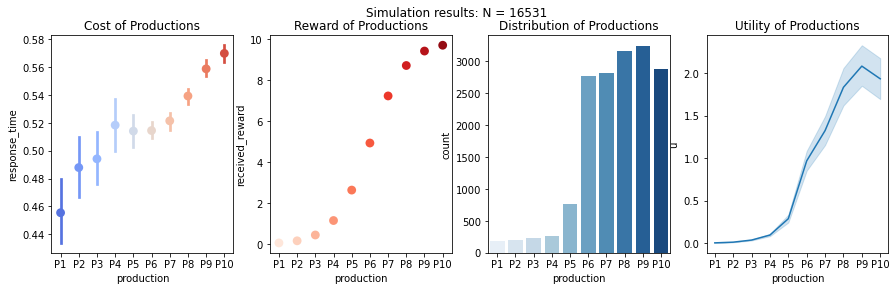

In [11]:
fig, ax =plt.subplots(1,4, figsize=(15,4))
fig.suptitle("Simulation results: N = {}".format(len(df1)))
sns.pointplot(x="production", y="response_time", order=order, data=df1, palette="coolwarm", ax=ax[0]).set_title('Cost of Productions')
sns.pointplot(x="production", y="received_reward", data=df3, order=order, palette="Reds", ax=ax[1]).set_title('Reward of Productions')
sns.countplot(x=df1['production'], order=order, palette="Blues", ax=ax[2]).set_title('Distribution of Productions')
sns.lineplot(x="production", y="u", data=df4, ax=ax[3]).set_title('Utility of Productions')
plt.show()

In [12]:
df1[['production', 'response_time']].groupby('production').agg(['mean', 'std'])

response_time          
                    mean       std
production                        
P1              0.455410  0.154844
P10             0.569965  0.165086
P2              0.487885  0.164928
P3              0.494156  0.150908
P4              0.518405  0.152751
P5              0.514112  0.157686
P6              0.514493  0.161132
P7              0.521469  0.160139
P8              0.539323  0.162849
P9              0.558860  0.166558

In [13]:
df3[['production', 'delivered_reward', 'received_reward']].groupby('production').agg(['mean', 'std'])

delivered_reward      received_reward     
                       mean  std            mean  std
production                                           
P1                   0.0669  0.0          0.0569  0.0
P10                  9.8201  0.0          9.7151  0.0
P2                   0.1799  0.0          0.1599  0.0
P3                   0.4743  0.0          0.4443  0.0
P4                   1.1920  0.0          1.1510  0.0
P5                   2.6894  0.0          2.6384  0.0
P6                   5.0000  0.0          4.9380  0.0
P7                   7.3106  0.0          7.2386  0.0
P8                   8.8080  0.0          8.7250  0.0
P9                   9.5257  0.0          9.4317  0.0

Text(0.5, 1.0, 'Cost of Productions')

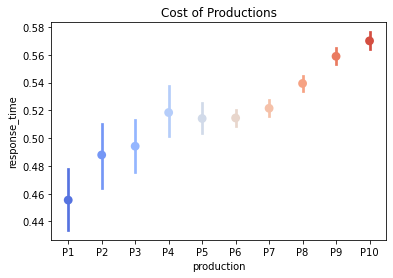

In [14]:
sns.pointplot(x="production", y="response_time", order=order, data=df1, palette="coolwarm").set_title('Cost of Productions')

In [15]:
df4

,epoch,production,u,utility,delivered_reward
0,0,P1,0.000000,1.727024,0.0669
1,0,P2,0.000000,-0.738434,0.1799
2,0,P3,0.000000,-0.390955,0.4743
3,0,P4,0.000000,0.476216,1.1920
4,0,P5,0.000000,-1.588123,2.6894
...,...,...,...,...,...
5,999,P6,0.000000,0.326506,5.0000
6,999,P7,0.000000,-0.683667,7.3106
7,999,P8,0.000000,-0.321197,8.8080
8,999,P9,0.000000,1.330045,9.5257
